In [1]:
import requests
import torch

from diffusers import DDIMScheduler, StableDiffusionPix2PixZeroPipeline


def download(embedding_url, local_filepath):
    r = requests.get(embedding_url)
    with open(local_filepath, "wb") as f:
        f.write(r.content)


model_ckpt = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPix2PixZeroPipeline.from_pretrained(
    model_ckpt, conditions_input_image=False, torch_dtype=torch.float16
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.to("cuda")


/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 16 files: 100%|███████████████████████████████████| 16/16 [00:49<00:00,  3.11s/it]
Keyword arguments {'conditions_input_image': False} are not expected by StableDiffusionPix2PixZeroPipeline and will be ignored.
Loading pipeline components...: 100%|████████████████████████| 7/7 [00:02<00:00,  2.56it/s]


StableDiffusionPix2PixZeroPipeline {
  "_class_name": "StableDiffusionPix2PixZeroPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "caption_generator": [
    null,
    null
  ],
  "caption_processor": [
    null,
    null
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "inverse_scheduler": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
prompt = "a high resolution painting of a cat in the style of van gogh"
src_embs_url = "https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/embeddings_sd_1.4/cat.pt"
target_embs_url = "https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/embeddings_sd_1.4/dog.pt"

for url in [src_embs_url, target_embs_url]:
    download(url, url.split("/")[-1])

src_embeds = torch.load(src_embs_url.split("/")[-1])
target_embeds = torch.load(target_embs_url.split("/")[-1])

images = pipeline(
    prompt,
    source_embeds=src_embeds,
    target_embeds=target_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
).images
images[0].save("edited_image_dog.png")

100%|██████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.41it/s]


In [3]:
import torch
from transformers import BlipForConditionalGeneration, BlipProcessor
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionPix2PixZeroPipeline

captioner_id = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(captioner_id)
model = BlipForConditionalGeneration.from_pretrained(captioner_id, torch_dtype=torch.float16, low_cpu_mem_usage=True)

sd_model_ckpt = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPix2PixZeroPipeline.from_pretrained(
    sd_model_ckpt,
    caption_generator=model,
    caption_processor=processor,
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()

Loading pipeline components...: 100%|████████████████████████| 6/6 [00:01<00:00,  3.45it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_pix2pix_zero.StableDiffusionPix2PixZeroPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [7]:
import requests
from PIL import Image

img_url = "https://github.com/pix2pixzero/pix2pix-zero/raw/main/assets/test_images/cats/cat_6.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((512, 512))
caption = pipeline.generate_caption(raw_image)
print(caption)

a photography of a black and white kitten in a field of daies


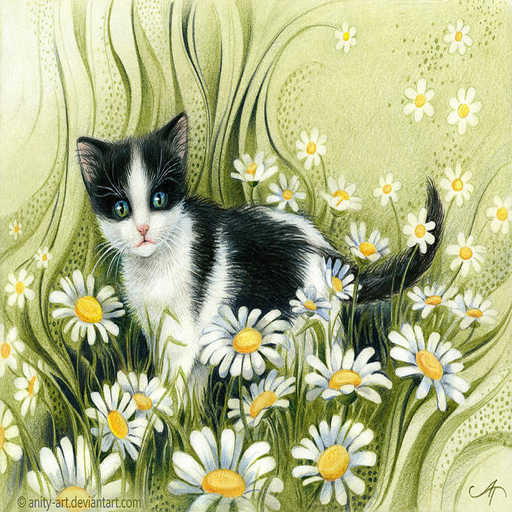

In [5]:
raw_image

In [6]:
generator = torch.manual_seed(0)
inv_latents = pipeline.invert(caption, image=raw_image, generator=generator).latents

100%|██████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s]


In [9]:
# See the "Generating source and target embeddings" section below to
# automate the generation of these captions with a pre-trained model like Flan-T5 as explained below.
source_prompts = ["a cat sitting on the street", "a cat playing in the field", "a face of a cat"]
target_prompts = ["a dog sitting on the street", "a dog playing in the field", "a face of a dog"]

source_embeds = pipeline.get_embeds(source_prompts, batch_size=2)
target_embeds = pipeline.get_embeds(target_prompts, batch_size=2)


image = pipeline(
    caption,
    source_embeds=source_embeds,
    target_embeds=source_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
    generator=generator,
    latents=inv_latents,
    negative_prompt=caption,
).images[0]
image.save("edited_image.png")

100%|██████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.64it/s]


In [10]:
raw_image = Image.open('Jockey/img00001.png').convert("RGB").resize((512, 512))
caption = pipeline.generate_caption(raw_image)
print(caption)

a photography of a horse racing on a track


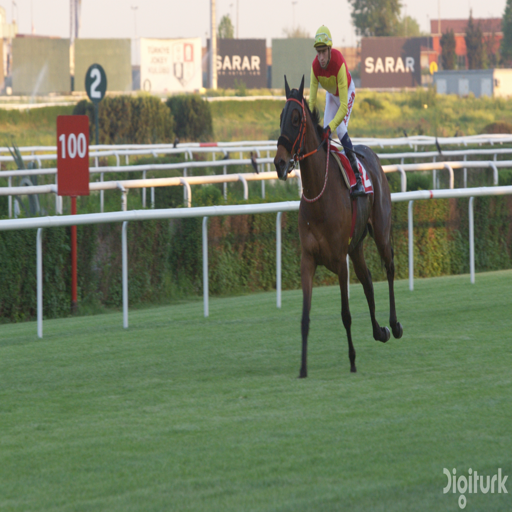

In [11]:
raw_image

In [ ]:
generator = torch.manual_seed(0)
inv_latents = pipeline.invert(caption, image=raw_image, generator=generator).latents

In [24]:
import pickle

with open('compressed_data.pkl', 'wb') as f:
    pickle.dump({'caption': caption, 'tensor': inv_latents}, f)

100%|██████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.61it/s]


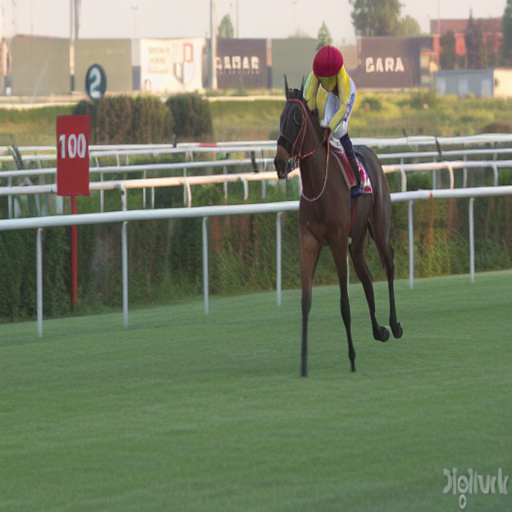

In [13]:
generator = torch.manual_seed(0)
inv_latents = pipeline.invert(caption, image=raw_image, generator=generator).latents
source_embeds = pipeline.get_embeds(caption, batch_size=2)
image = pipeline(
    caption,
    source_embeds=source_embeds,
    target_embeds=source_embeds,
    num_inference_steps=50,
    cross_attention_guidance_amount=0.15,
    generator=generator,
    latents=inv_latents,
    negative_prompt=caption,
).images[0]
image

In [14]:
image.save('pix2pixjockey_test.png')

In [25]:
import os
def calculate_bpp(data_path, image_size):
    # Get the file size of the image in bytes
    file_size_bytes = os.path.getsize(data_path)

    # Convert file size to bits
    file_size_bits = file_size_bytes * 8

    width, height = image_size

    # Calculate total number of pixels
    total_pixels = width * height

    # Calculate bits per pixel
    bpp = file_size_bits / total_pixels

    return bpp

In [26]:
calculate_bpp('compressed_data.pkl',(512,512))

1.0147705078125

In [22]:
import numpy as np
def calculate_psnr(original_image, reconstructed_image):
    # Convert images to numpy arrays
    original_array = np.array(original_image)
    reconstructed_array = np.array(reconstructed_image)

    # Calculate mean squared error
    mse = np.mean((original_array - reconstructed_array) ** 2)

    # Maximum possible pixel value
    max_pixel_value = 255  # Assuming 8-bit images

    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr

psnr = calculate_psnr(raw_image, image)

# Print PSNR
print('PSNR:', psnr)

PSNR: 31.69601316009159
